# Step 5.4: Deep Learning - Autoencoder

In [13]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm

import tensorflow.keras as keras

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [2]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

In [3]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [4]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [5]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

In [74]:
# Scale the training and test data
X_train_scaled = np.array([(k - np.min(k)) / (np.max(k - np.min(k)))  for k in X_train])
X_test_scaled = np.array([(k - np.min(k)) / (np.max(k - np.min(k)))  for k in X_test])

In [35]:
n_inputs = asteroids_X.shape[1]
print(f"Number of inputs: {n_inputs}")

Number of inputs: 49


In [80]:
# Let's create an autoencoder
n_bottleneck = 2

# Input layer
in_layer = keras.layers.Input(shape=(n_inputs,))

# First hidden layer (encoder side)
enc_hid_lay1 = keras.layers.Dense(25)(in_layer)
enc_hid_lay1 = keras.layers.BatchNormalization()(enc_hid_lay1)
enc_hid_lay1 = keras.layers.LeakyReLU()(enc_hid_lay1)

# Second hidden layer (encoder side)
enc_hid_lay2 = keras.layers.Dense(8)(enc_hid_lay1)
enc_hid_lay2 = keras.layers.BatchNormalization()(enc_hid_lay2)
enc_hid_lay2 = keras.layers.LeakyReLU()(enc_hid_lay2)

# Encoder ("Bottleneck" of the Autoencoder)
bottleneck_lay = keras.layers.Dense(n_bottleneck, activation='linear')(enc_hid_lay2)
bottleneck_lay = keras.layers.BatchNormalization()(bottleneck_lay)

# First hidden layer (decoder side)
dec_hid_lay1 = keras.layers.Dense(8)(bottleneck_lay)
dec_hid_lay1 = keras.layers.BatchNormalization()(dec_hid_lay1)
dec_hid_lay1 = keras.layers.LeakyReLU()(dec_hid_lay1)

# Second hidden layer (decoder side)
dec_hid_lay2 = keras.layers.Dense(25)(dec_hid_lay1)
dec_hid_lay2 = keras.layers.BatchNormalization()(dec_hid_lay2)
dec_hid_lay2 = keras.layers.LeakyReLU()(dec_hid_lay2)

# Ouput layer (same size as input layer)
out_layer = keras.layers.Dense(n_inputs)(dec_hid_lay2)

# Create model
model = keras.models.Model(inputs=in_layer, outputs=out_layer)

# Compile the model. Use the Mean Squred Error as the loss function. Background: An Autoencoder is a regression function
# that maps the input value directly to the output values
model.compile(optimizer='adam', loss='mse')

# Train the model
end_epoch = 100
batch_size = 32
history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1, 
                    validation_data=(X_test_scaled, X_test_scaled))

Epoch 1/100
34/34 [==============================] - 1s 6ms/step - loss: 0.6943 - val_loss: 0.4405
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 0.3696 - val_loss: 0.3135
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 0.1995 - val_loss: 0.2235
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0982 - val_loss: 0.1651
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.1065
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0781
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0587
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0451
Epoch 9/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0199 - val_loss: 0.0358
Epoch 10/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0183 - val_loss: 0.0291
Epoch 11/

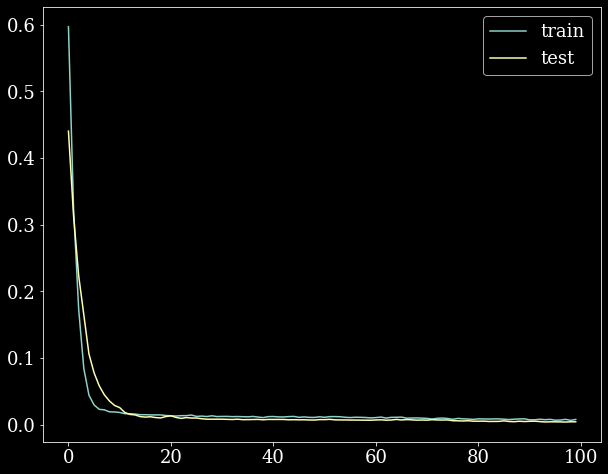

In [85]:
# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# Limit the x axis
plt.xlim(0, end_epoch)

# ... aaaaand plot!
pyplot.show()

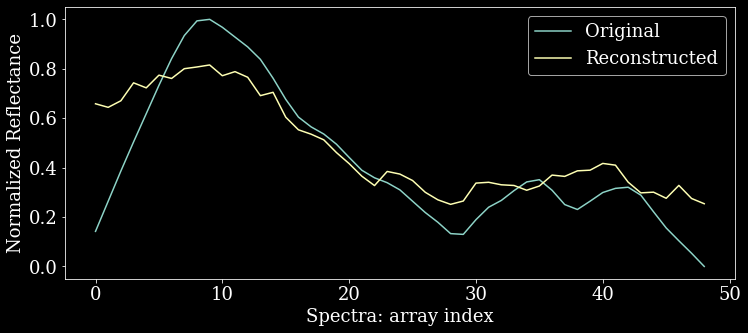

In [91]:
index_val = 6

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(X_train_scaled[index_val], label='Original')
plt.plot(model.predict(X_train_scaled)[index_val], label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
pyplot.show()

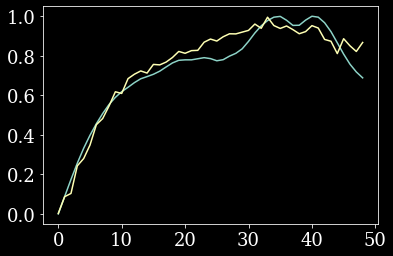

In [83]:
# Create dataframe that contains the encoder values (2 values at bottleneck) and the corresponding
# class to see whether the autoencoder values cluster in a way

# Build the encoder
encoder = keras.models.Model(inputs=in_layer, outputs=bottleneck_lay)

# Encode the trained spectra
X_train_encoded = encoder.predict(X_train_scaled)

# Create the dataframe
encoded_train_df = pd.DataFrame(np.hstack((X_train_encoded, y_train[np.newaxis].transpose())),
                                columns=["enc1", "enc2", "class"])

# Change the dtype to float
encoded_train_df.loc[:, "enc1"] = encoded_train_df["enc1"].astype(float)
encoded_train_df.loc[:, "enc2"] = encoded_train_df["enc2"].astype(float)

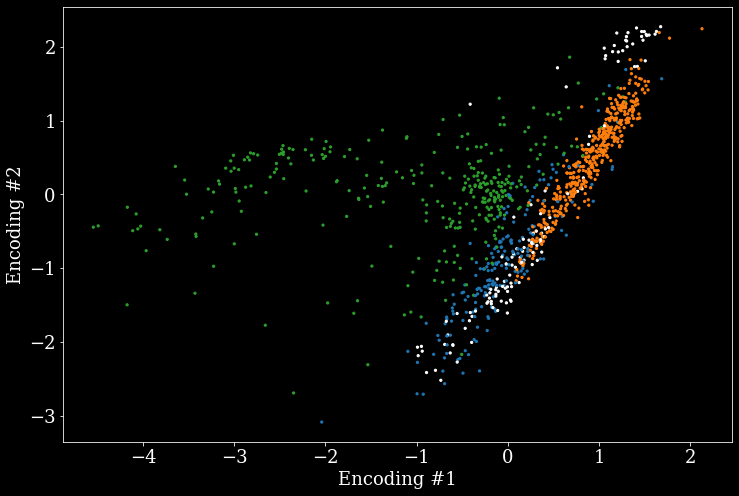

In [84]:
# Plot now the autoencoder values

# Create a dictionary to color the classes
color_dict = {'Other': 'w',
              'S': 'tab:orange',
              'C': 'tab:green',
              'X': 'tab:blue'}

# Set a plot
plt.figure(figsize=(12,8))

# Create a scatter plot with the encod
plt.scatter(encoded_train_df["enc1"], encoded_train_df["enc2"], marker='o', s=5, alpha=1, color=encoded_train_df.apply(lambda x: color_dict.get(x["class"]), axis=1).values)

plt.xlabel("Encoding #1")
plt.ylabel("Encoding #2")

plt.savefig("temp.png")
plt.show()